In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from beamline.integrators import IntegratorConfig, symplectic_integrator, flow_integrator, rk_integrator

jax.config.update("jax_enable_x64", True)


In [2]:
def kinetic_energy(state, mass):
    _, p = state
    p3 = p.reshape(-1, 2)
    return 0.5 * jnp.sum(p3 * p3 / mass[:, None])


def potential_energy(state, mass):
    q, _ = state
    q3 = q.reshape(-1, 2)
    i, j = jnp.tril_indices_from(q3, -1)
    invdistance = jnp.pow(jnp.sum((q3[i] - q3[j]) ** 2, axis=-1), -0.5)
    return -jnp.sum(mass[i] * mass[j] * invdistance)


def hamiltonian(state, mass):
    return kinetic_energy(state, mass) + potential_energy(state, mass)

In [3]:
q0 = jnp.array([0.0, 1.0, 1.0, 0.0, -1.0, 0.0])
p0 = jnp.zeros(6)
state0 = jnp.array((q0, p0))
mass0 = jnp.array([1.0, 2.0, 3.0])


# much more fun
# state0 = jnp.array(
#     [
#         [
#             0.6733224710678404,
#             0.0006444390845759389,
#             -0.10733177312062013,
#             -0.06875982027365993,
#             -0.48621964160889125,
#             0.3789584004876191,
#         ],
#         [
#             3.6177035896412204,
#             -0.5416124691063872,
#             -2.475260691714918,
#             0.970244850494132,
#             -1.1424428979263148,
#             -0.428632381387655,
#         ],
#     ]
# )
def hamiltonian_mass0(state):
    return hamiltonian(state, mass0)


dt = 1e-2
Nsteps = 1000
times = jnp.linspace(0, Nsteps * dt, Nsteps)
dtstep = dt / 50

In [4]:
leapfrog_config = IntegratorConfig((1, 0), (0, 1), dtstep)
q, p, H = symplectic_integrator(hamiltonian_mass0, state0, times, leapfrog_config)
leapfrog_track = jnp.array((q, p))
leapfrog_energy = H

verlet2_config = IntegratorConfig((0, 1), (0.5, 0.5), dtstep)
q, p, H = symplectic_integrator(hamiltonian_mass0, state0, times, verlet2_config)
verlet2_track = jnp.array((q, p))
verlet2_energy = H

# https://cds.cern.ch/record/143981/files/cer-000055082.pdf
ruth3_config = IntegratorConfig((1, -2 / 3, 2 / 3), (-1 / 24, 3 / 4, 7 / 24), dtstep)
q, p, H = symplectic_integrator(hamiltonian_mass0, state0, times, ruth3_config)
ruth3_track = jnp.array((q, p))
ruth3_energy = H


def make_yoshida4():
    x0 = -(2 ** (1 / 3)) / (2 - 2 ** (1 / 3))
    x1 = 1 / (2 - 2 ** (1 / 3))
    c1c4 = x1 / 2
    c2c3 = (x1 + x0) / 2
    d1d3 = x1
    d2 = x0
    return IntegratorConfig(
        c=(c1c4, c2c3, c2c3, c1c4),
        d=(d1d3, d2, d1d3, 0.0),
        dt=dtstep
    )


yoshida4_config = make_yoshida4()
q, p, H = symplectic_integrator(hamiltonian_mass0, state0, times, yoshida4_config)
yoshida4_track = jnp.array((q, p))
yoshida4_energy = H

/Users/ncsmith/src/beamline/src/beamline/integrators.py:23: UserWarning: Failed to satisfy the symplectic condition at second order for IntegratorConfig(c=(1, 0), d=(0, 1), dt=0.0002)
  warnings.warn(
/Users/ncsmith/src/beamline/src/beamline/integrators.py:33: UserWarning: Failed to satisfy symmetric condition for IntegratorConfig(c=(1, -0.6666666666666666, 0.6666666666666666), d=(-0.041666666666666664, 0.75, 0.2916666666666667), dt=0.0002)
  warnings.warn(f"Failed to satisfy symmetric condition for {self}")


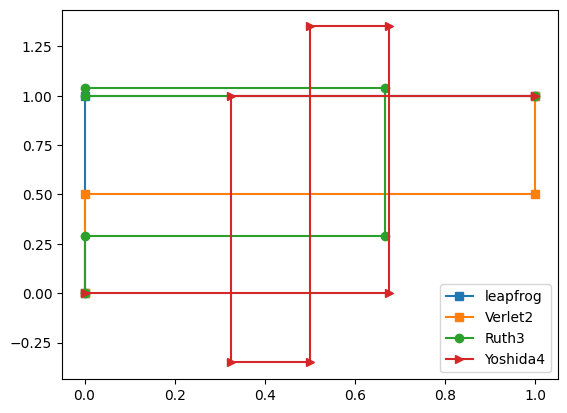

In [5]:
fig, ax = plt.subplots()

ax.plot(*leapfrog_config.steps().T, marker="s", label="leapfrog")
ax.plot(*verlet2_config.steps().T, marker="s", label="Verlet2")
ax.plot(*ruth3_config.steps().T, marker="o", label="Ruth3")
ax.plot(*yoshida4_config.steps().T, marker=">", label="Yoshida4")

ax.legend()

In [6]:
q, p, H, flow = flow_integrator(hamiltonian_mass0, state0, times)
flow2_track = jnp.array((q, p))
flow2_energy = H

In [7]:
q, p, H = rk_integrator(hamiltonian_mass0, state0, times)
rk_track = jnp.array((q, p))
rk_energy = H

In [8]:
%timeit symplectic_integrator(hamiltonian_mass0, state0, times, verlet2_config)
%timeit rk_integrator(hamiltonian_mass0, state0, times)

20.2 ms ± 262 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14 ms ± 112 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
def error(state):
    q0, p0 = state
    dHdq = jax.jacobian(lambda q, p: hamiltonian_mass0((q, p)), argnums=0)
    dHdp = jax.jacobian(lambda q, p: hamiltonian_mass0((q, p)), argnums=1)

    dotq = jax.jacobian(lambda q, p: dHdp(q, p) @ (q - q0) - dHdq(q, p) @ (p - p0), argnums=0)
    dotp = jax.jacobian(lambda q, p: dHdp(q, p) @ (q - q0) - dHdq(q, p) @ (p - p0), argnums=1)
    return dotq(q0, p0), dotp(q0, p0)

error(verlet2_track[:, 10])

(Array([-0.0356444 , -0.17772612, -0.11092459,  0.0355205 ,  0.08583119,
         0.03556171], dtype=float64),
 Array([-0.36121516, -1.79101835, -2.23473401,  0.71490884,  2.59594917,
         1.07610951], dtype=float64))

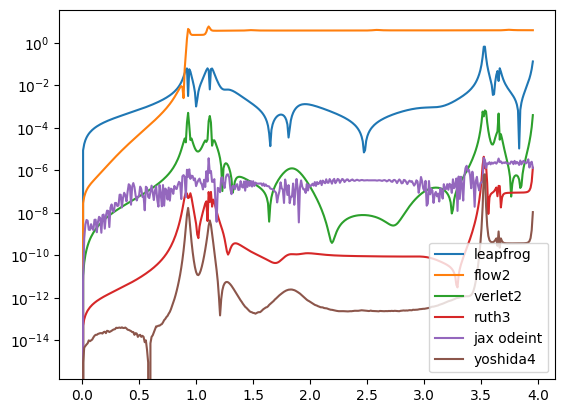

In [10]:
fig, ax = plt.subplots()

H0 = hamiltonian_mass0(state0)
# ax.axhline(H0, color="k", linestyle=":", label="initial energy")
cut = times < 3.96
ax.plot(times[cut], abs(leapfrog_energy[cut] - H0), label="leapfrog")
ax.plot(times[cut], abs(flow2_energy[cut] - H0), label="flow2")
ax.plot(times[cut], abs(verlet2_energy[cut] - H0), label="verlet2")
ax.plot(times[cut], abs(ruth3_energy[cut] - H0), label="ruth3")
ax.plot(times[cut], abs(rk_energy[cut] - H0), label="jax odeint")
ax.plot(times[cut], abs(yoshida4_energy[cut] - H0), label="yoshida4")
# a potential measure of the error in the flow?

ax.set_yscale("log")
ax.legend()

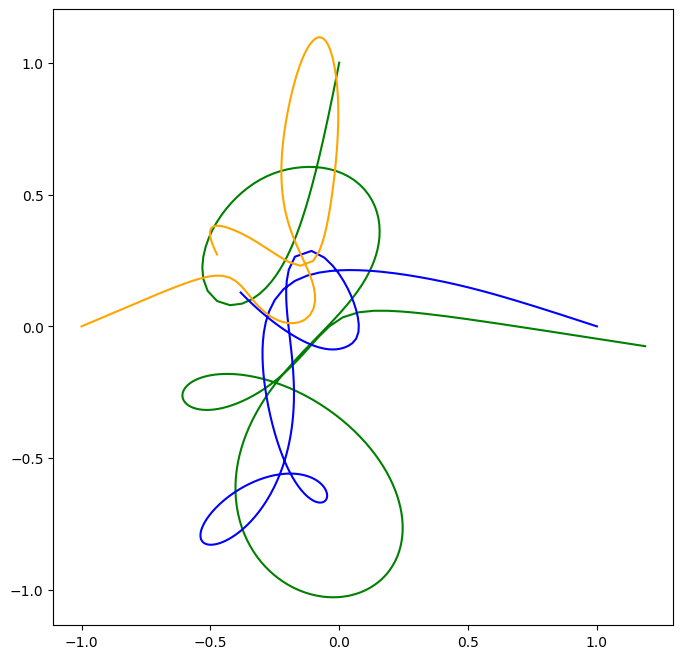

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))

paths = verlet2_track[0].reshape(-1, 3, 2)[cut, :, :]
ax.plot(paths[:, 0, 0], paths[:, 0, 1], color="green")
ax.plot(paths[:, 1, 0], paths[:, 1, 1], color="blue")
ax.plot(paths[:, 2, 0], paths[:, 2, 1], color="orange")

# paths = yoshida4_track[1].reshape(-1, 3, 2)[cut, :, :]
# ax.plot(paths[:, 0, 0], paths[:, 0, 1], color="green", linestyle="--")
# ax.plot(paths[:, 1, 0], paths[:, 1, 1], color="blue", linestyle="--")
# ax.plot(paths[:, 2, 0], paths[:, 2, 1], color="orange", linestyle="--")

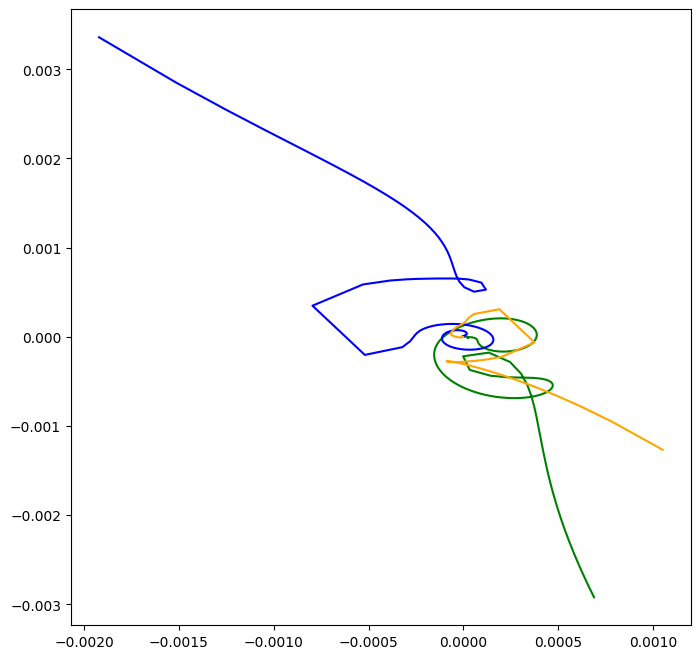

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))

dpath = (rk_track[0] - verlet2_track[0]).reshape(-1, 3, 2)[cut, :, :]
ax.plot(dpath[:, 0, 0], dpath[:, 0, 1], color="green")
ax.plot(dpath[:, 1, 0], dpath[:, 1, 1], color="blue")
ax.plot(dpath[:, 2, 0], dpath[:, 2, 1], color="orange")

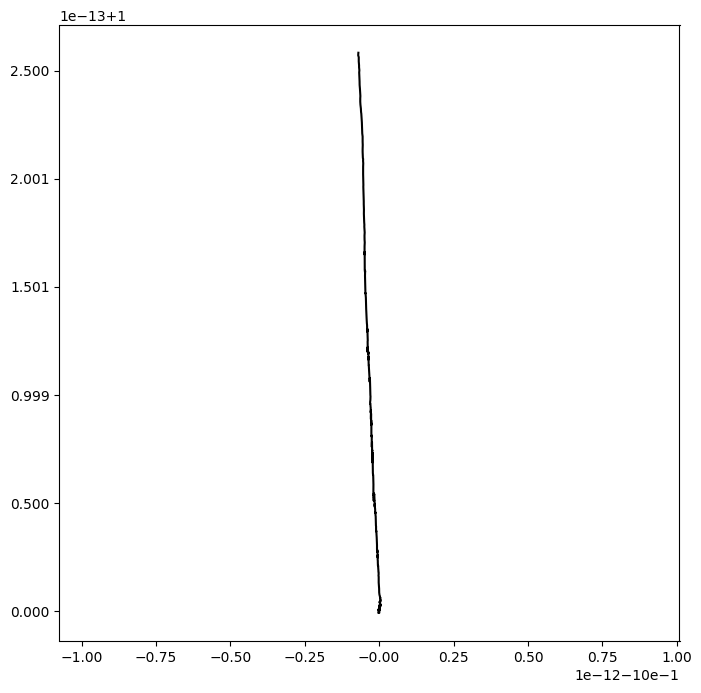

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))

cmpath = jnp.sum(verlet2_track[0].reshape(-1, 3, 2)[cut, :, :] * mass0[:, None], axis=1)
ax.plot(cmpath[:, 0], cmpath[:, 1], color="k")

In [14]:
def func(mass):
    q, p, H = symplectic_integrator(lambda s: hamiltonian(s, mass), state0, times, verlet2_config)
    # rk crashes!
    # q, p, H = rk_integrator(lambda s: hamiltonian(s, mass), state0, times)
    return q, p, H

qdot, pdot, Hdot = jax.jacfwd(func)(mass0)
%timeit symplectic_integrator(hamiltonian_mass0, state0, times, ruth3_config)
%timeit jax.jacfwd(func)(mass0)

28.7 ms ± 144 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
315 ms ± 37.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


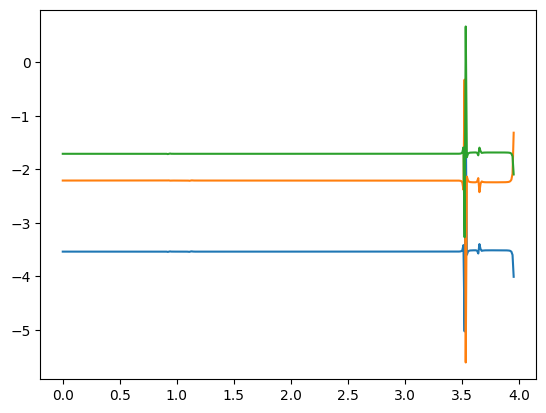

In [15]:
plt.plot(times[cut], Hdot[cut])

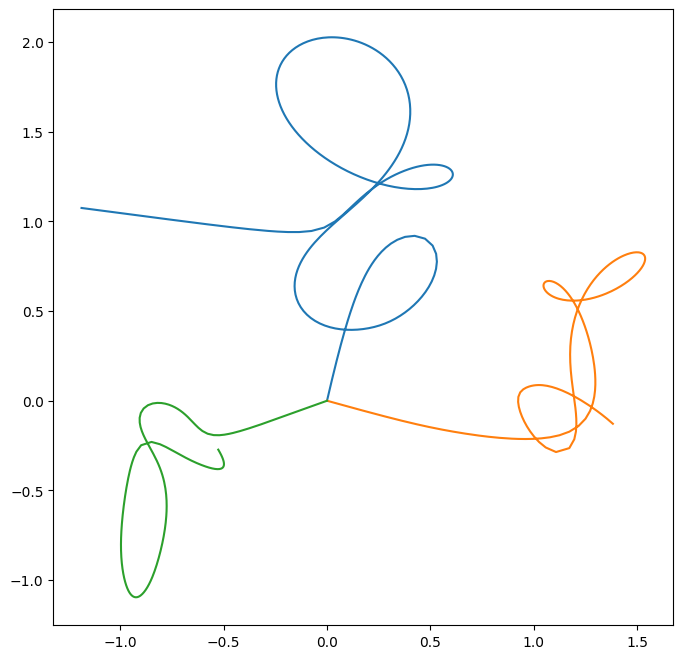

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))

cmpath = jnp.sum(qdot.reshape(-1, 3, 2, 3)[cut, :, :, :] * mass0[:, None, None], axis=1)
ax.plot(cmpath[:, 0, 0], cmpath[:, 1, 0])
ax.plot(cmpath[:, 0, 1], cmpath[:, 1, 1])
ax.plot(cmpath[:, 0, 2], cmpath[:, 1, 2])

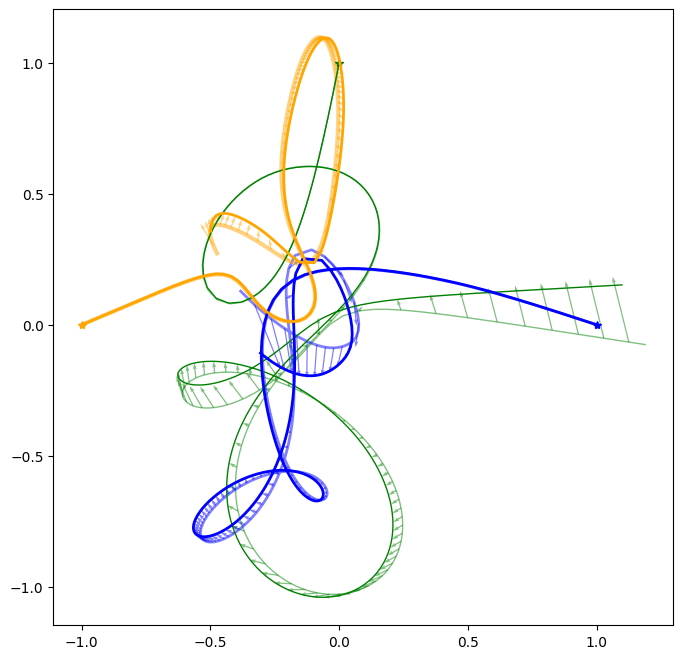

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))

paths = verlet2_track[0].reshape(-1, 3, 2)[cut, :, :]
dpath_dm0 = qdot.reshape(-1, 3, 2, 3)[cut, :, :, 0]

dm = 0.01
qnew = symplectic_integrator(lambda s: hamiltonian(s, mass0 + jnp.array([dm, 0.0, 0.0])), state0, times, verlet2_config)[0].reshape(-1, 3, 2)[cut]

n = 3
ax.plot(paths[:, 0, 0], paths[:, 0, 1], lw=mass0[0], alpha=0.5, color="green")
ax.plot(paths[:, 1, 0], paths[:, 1, 1], lw=mass0[1], alpha=0.5, color="blue")
ax.plot(paths[:, 2, 0], paths[:, 2, 1], lw=mass0[2], alpha=0.5, color="orange")
ax.plot(paths[0, 0, 0], paths[0, 0, 1], marker="*", color="green")
ax.plot(paths[0, 1, 0], paths[0, 1, 1], marker="*", color="blue")
ax.plot(paths[0, 2, 0], paths[0, 2, 1], marker="*", color="orange")

fig.savefig("three_body.png")

scale = 1 / dm
ax.quiver(paths[::n, 0, 0], paths[::n, 0, 1], dpath_dm0[::n, 0, 0], dpath_dm0[::n, 0, 1], color="green", width=0.002, alpha=0.5, scale_units="xy", scale=scale)
ax.quiver(paths[::n, 1, 0], paths[::n, 1, 1], dpath_dm0[::n, 1, 0], dpath_dm0[::n, 1, 1], color="blue", width=0.002, alpha=0.5, scale_units="xy", scale=scale)
ax.quiver(paths[::n, 2, 0], paths[::n, 2, 1], dpath_dm0[::n, 2, 0], dpath_dm0[::n, 2, 1], color="orange", width=0.002, alpha=0.5, scale_units="xy", scale=scale)
fig.savefig("three_body_dm3.png")

ax.plot(qnew[:, 0, 0], qnew[:, 0, 1], lw=mass0[0], color="green")
ax.plot(qnew[:, 1, 0], qnew[:, 1, 1], lw=mass0[1], color="blue")
ax.plot(qnew[:, 2, 0], qnew[:, 2, 1], lw=mass0[1], color="orange")
fig.savefig("three_body_dm3new.png")


In [18]:
# validate bias by simulating many initial conditions
# and computing derivatives and comparing with finite differences